# Import necessary libraries

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import SimpleImputer

In [24]:
# Load the dataset
data = pd.read_csv('E:\\Project_Nokia_Intern\\Predictive-Maintenance\\predictive_maintenance.csv')

# Display basic information about the dataset
print(data.info())
print(f"Total rows in the dataset: {len(data)}")
print(f"Dataset shape (rows, columns): {data.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None
Total rows in the dataset: 10000
Dataset shape (rows, columns): (10000, 10)


In [25]:
# Drop unnecessary columns
columns_to_drop = ["UDI", "Product ID", "Target"]
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
print(f"Columns {', '.join(columns_to_drop)} dropped if present.")

Columns UDI, Product ID, Target dropped if present.


In [26]:
# Convert temperatures from Kelvin to Celsius and rename columns
for col in ['Air temperature [K]', 'Process temperature [K]']:
    if col in data.columns:
        new_col = col.replace('[K]', '[C]')
        data[new_col] = data[col] - 273.15
        data = data.drop(columns=[col])

In [27]:
# Create temperature difference
if 'Air temperature [C]' in data.columns and 'Process temperature [C]' in data.columns:
    data['Temp_difference [C]'] = data['Process temperature [C]'] - data['Air temperature [C]']

In [28]:
# Split data into features (X) and target (y)
X = data.drop('Failure Type', axis=1)
y = data['Failure Type']

In [29]:
# Encode categorical columns
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

In [30]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [31]:
# Check the distribution of the target classes before SMOTE
print("Original class distribution:")
print(y.value_counts())

Original class distribution:
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [32]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [33]:
# Check the distribution of the target classes after SMOTE
print("Resampled class distribution:")
print(pd.Series(y_resampled).value_counts())

Resampled class distribution:
Failure Type
No Failure                  9652
Power Failure               9652
Tool Wear Failure           9652
Overstrain Failure          9652
Random Failures             9652
Heat Dissipation Failure    9652
Name: count, dtype: int64


In [34]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [35]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# Define a smaller parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 8]
}

In [37]:
# Perform RandomizedSearchCV with fewer iterations
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [4, 8],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=42, verbose=2)

In [38]:
# Get best model
best_rf = random_search.best_estimator_

# Make predictions
predictions = best_rf.predict(X_test_scaled)

In [39]:
# Evaluate the model using accuracy, F1-score, balanced accuracy, and confusion matrix
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')
balanced_acc = balanced_accuracy_score(y_test, predictions)

In [40]:
print(f'Random Forest Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print('Classification Report:')
print(classification_report(y_test, predictions))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

Random Forest Accuracy: 0.9908
F1 Score: 0.9908
Balanced Accuracy: 0.9910
Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00      1881
              No Failure       1.00      0.95      0.97      1962
      Overstrain Failure       0.99      1.00      1.00      1933
           Power Failure       0.99      1.00      1.00      1957
         Random Failures       0.99      1.00      0.99      1916
       Tool Wear Failure       0.98      1.00      0.99      1934

                accuracy                           0.99     11583
               macro avg       0.99      0.99      0.99     11583
            weighted avg       0.99      0.99      0.99     11583

Confusion Matrix:
[[1880    1    0    0    0    0]
 [   0 1863   14   11   25   49]
 [   0    0 1933    0    0    0]
 [   0    0    0 1957    0    0]
 [   0    4    0    0 1912    0]
 [   0    0    2    0    0 1932]]


In [41]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

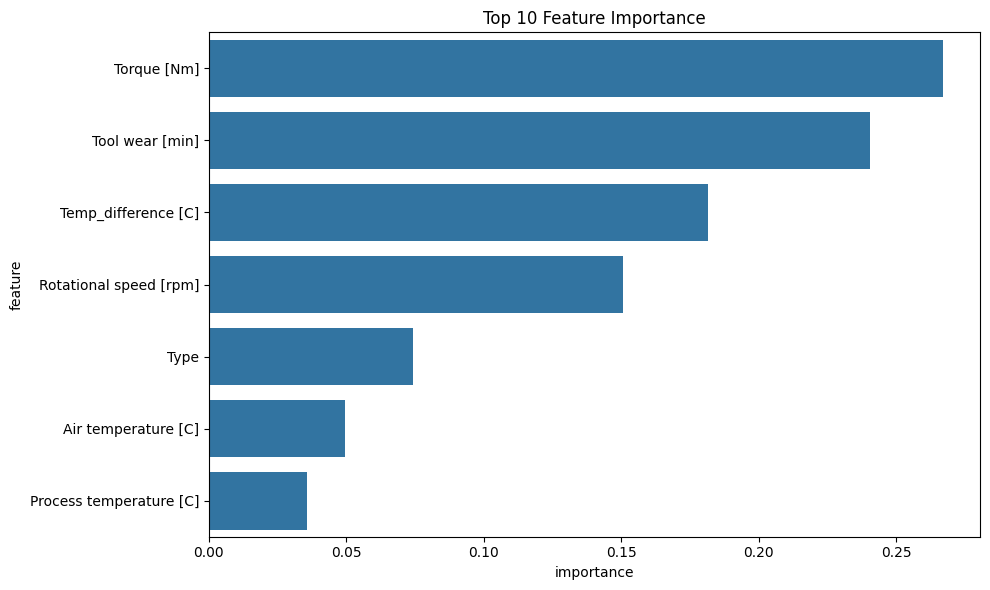

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [43]:
# Save the model, scaler, and label encoder for future use
joblib.dump(best_rf, 'best_random_forest_model_fast.pkl')
joblib.dump(scaler, 'scaler_fast.pkl')
joblib.dump(label_encoder, 'label_encoder_fast.pkl')

['label_encoder_fast.pkl']

In [44]:
# During training or testing
print(X_train.columns)  # Should match the columns used in prediction

Index(['Type', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Air temperature [C]', 'Process temperature [C]',
       'Temp_difference [C]'],
      dtype='object')
